In [1]:
# !pip install figurefirst
# !pip install pingouin

In [6]:
import pandas as pd
import numpy as np
import itertools


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import scipy
import scipy.stats as stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

#importing the dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable
from figurefirst import FigureLayout,mpl_functions



In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
df = pd.read_csv('../Dronecs791data_cleaned.csv')
df.keys()

Index(['Timestamp', 'consent', 'time_started', 'age_group', 'gender',
       'race_ethnicity', 'eye_sight_issues', 'familarity_with_robots',
       'familarity_with_drones', 'comfort_video1', 'comfort_video2',
       'comfort_video3', 'comfort_video4', 'video5_easy_to_focus',
       'building_comfort_video5', 'video6_easy_to_focus',
       'building_comfort_video6', 'video7_easy_to_focus',
       'building_comfort_video7', 'video8_easy_to_focus',
       'building_comfort_video8', 'video9_easy_to_focus',
       'building_comfort_video9', 'video10_easy_to_focus',
       'building_comfort_video10', 'overall_experience',
       'experience_discomfort_overall', 'experience_description',
       'easy_to_track', 'why_easy_to_track',
       'easy_to_understand_drone_trajectory',
       'stabilization_experience_improvement', 'learn_to_fly', 'time_end'],
      dtype='object')

### Mapping the age for easier usage

In [9]:
age_group_mapping = {
    '18-24': 1,
    '25-34': 2,
    '35-44': 3
}

ethnicity_group_mapping = {
    'White': 1,
    'Asian': 2,
    'Hispanic': 3,
    'Black': 4
}


df.age_group = df.age_group.map(age_group_mapping)
df['ethnicity'] = df.race_ethnicity.map(ethnicity_group_mapping)
df['eye_sight_issues'] = df['eye_sight_issues'].replace({'No': 0, 'Yes': 1})
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 2})
df.stabilization_experience_improvement = df.stabilization_experience_improvement.replace({'No': 0, 'Yes': 1})
df.easy_to_track = df.easy_to_track.replace({'Mannequin': 1, 'Skyline scene': 2})

### Time taken for the survey

In [10]:
df['time_started'] = pd.to_datetime(df['time_started'], format='%H:%M')
df['time_end'] = pd.to_datetime(df['time_end'], format='%H:%M')

df['time_difference'] = df['time_end'] - df['time_started']
df['minutes_taken'] = df['time_difference'].dt.total_seconds() / 60

In [11]:
df.loc[22, 'minutes_taken'] = 18.2

### Comfort Label Summarization

In [12]:
discomfort_df = df[['comfort_video1','comfort_video3','building_comfort_video5','building_comfort_video7', 'building_comfort_video9']].copy()
comfort_df = df[['comfort_video2','comfort_video4','building_comfort_video6','building_comfort_video8', 'building_comfort_video10']].copy()

In [ ]:
object_df = df[['comfort_video1','comfort_video3']].copy()
skyline_df = df[['building_comfort_video5','building_comfort_video7']].copy()

In [47]:
## linear > rotational 
print('comparing linear trajectories',np.median(df.comfort_video1), np.median(df.building_comfort_video5))
print('comparing curve trajectories',np.median(df.comfort_video3), np.median(df.building_comfort_video7))

comparing linear trajectories 4.0 3.0
comparing curve trajectories 3.5 4.0


In [46]:
## delta comfort
print("comparing object",np.median(df.comfort_video1), np.median(df.comfort_video3))
print("comparing  scene",np.median(df.building_comfort_video5), np.median(df.building_comfort_video7))


comparing object 4.0 3.5
comparing  scene 3.0 4.0


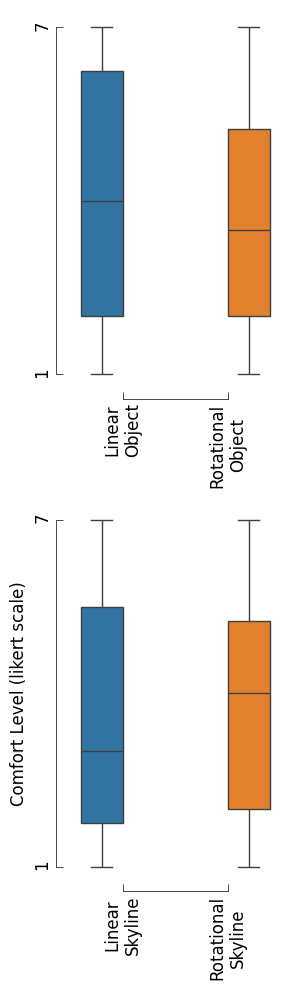

In [44]:
# Plot for 
# H1: Participants will have a higher comfort ranking for linear trajectories
# H2: change in comfort for skyline is smaller than change in comfort for object

f,ax=plt.subplots(2,1,figsize=(3,10))
ax[0].grid(False)
ax[1].grid(False)


sns.boxplot(data=object_df, ax=ax[0], dodge=True, )
# sns.stripplot(data=linear_df_stabilized, ax=ax[0], dodge=True, color='black', alpha=0.5)
sns.boxplot(data=skyline_df, ax=ax[1], dodge=True)
# sns.stripplot(data=linear_df, ax=ax[1], dodge=True, color='black', alpha=0.5)


mpl_functions.adjust_spines(ax[0],['left','bottom'],
                            spine_locations={'right': 4, 'bottom': 5},
                            smart_bounds=True,
                            yticks=[1,7],
                            linewidth=0.5)

mpl_functions.adjust_spines(ax[1],['left','bottom'],
                            spine_locations={'right': 4, 'bottom': 5},
                            smart_bounds=True,
                            yticks=[1,7],
                            linewidth=0.5)

label1=['Linear\nObject', 'Rotational\nObject']
label2=['Linear\nSkyline', 'Rotational\nSkyline']

ax[0].set_xticklabels(label1,rotation=90)
ax[1].set_xticklabels(label2,rotation=90)

ax[0].set_yticklabels(['1','7'],rotation=90)
ax[1].set_yticklabels(['1','7'],rotation=90)

ax[1].set_ylabel('Comfort Level (likert scale)')

mpl_functions.set_fontsize(ax[0],12)
mpl_functions.set_fontsize(ax[1],12)
f.tight_layout()

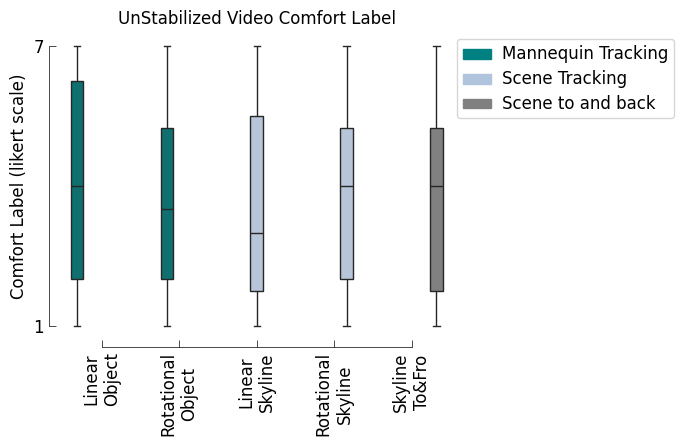

In [17]:
## Plot for H3: Participants will have a higher comfort when stabilization is applied to the video footage.

f,ax=plt.subplots(1,1,figsize=(5,4))
ax.grid(False)

box_colors = {
    'comfort_video1': 'teal', 'comfort_video3': 'teal',  # object
    'building_comfort_video5': 'lightsteelblue', 'building_comfort_video7': 'lightsteelblue',  # skyline
    'building_comfort_video9': 'grey',  # forward backward
}

palette = [box_colors[col] for col in discomfort_df.columns]

sns.boxplot(data=discomfort_df, ax=ax, dodge=True, palette=palette)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'right': 4, 'bottom': 5},
                            smart_bounds=True,
                            yticks=[1,7],

                            linewidth=0.5)

labels=['Linear\nObject', 'Rotational\nObject', 'Linear\nSkyline', 'Rotational\nSkyline', 'Skyline\nTo&Fro']
ax.set_xticklabels(labels,rotation=90)
ax.set_ylabel('Comfort Label (likert scale)')
ax.set_title('UnStabilized Video Comfort Label')

blue_patch = mpatches.Patch(color='teal', label='Mannequin Tracking')
green_patch = mpatches.Patch(color='lightsteelblue', label='Scene Tracking')
red_patch = mpatches.Patch(color='grey', label='Scene to and back')


ax.legend(handles=[blue_patch, green_patch, red_patch], bbox_to_anchor=(1, 1))

mpl_functions.set_fontsize(ax,12)

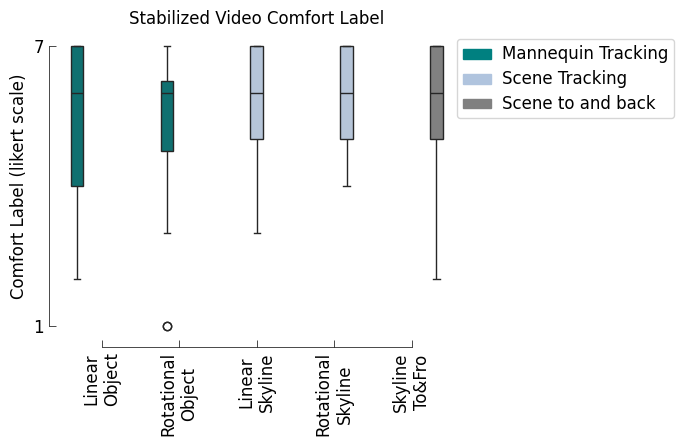

In [12]:
f,ax=plt.subplots(1,1,figsize=(5,4))
ax.grid(False)

box_colors = {
    'comfort_video2': 'teal', 'comfort_video4': 'teal',  # object
    'building_comfort_video6': 'lightsteelblue', 'building_comfort_video8': 'lightsteelblue',  # skyline
    'building_comfort_video10': 'grey',  # forward backward
}

palette = [box_colors[col] for col in comfort_df.columns]

sns.boxplot(data=comfort_df, ax=ax, dodge=True, palette=palette)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'right': 4, 'bottom': 5},
                            smart_bounds=True,
                            yticks=[1,7],

                            linewidth=0.5)

labels=['Linear\nObject', 'Rotational\nObject', 'Linear\nSkyline', 'Rotational\nSkyline', 'Skyline\nTo&Fro']
ax.set_xticklabels(labels,rotation=90)
ax.set_ylabel('Comfort Label (likert scale)')
ax.set_title('Stabilized Video Comfort Label')

blue_patch = mpatches.Patch(color='teal', label='Mannequin Tracking')
green_patch = mpatches.Patch(color='lightsteelblue', label='Scene Tracking')
red_patch = mpatches.Patch(color='grey', label='Scene to and back')


ax.legend(handles=[blue_patch, green_patch, red_patch], bbox_to_anchor=(1, 1))

mpl_functions.set_fontsize(ax,12)

In [19]:
d_mean = discomfort_df.mean(axis=1)
c_mean = comfort_df.mean(axis=1)
df['discomfort_mean']=d_mean
df['comfort_mean']=c_mean

### Comfort Model

In [20]:
model_comfort=smf.ols(formula="""comfort_mean ~ minutes_taken + age_group + gender + ethnicity + eye_sight_issues +
                                                      familarity_with_robots +familarity_with_drones + overall_experience +
                                                      easy_to_track + stabilization_experience_improvement +
                                                      easy_to_understand_drone_trajectory """, data=df).fit()
print(model_comfort.summary())

                            OLS Regression Results                            
Dep. Variable:           comfort_mean   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     9.167
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           0.000298
Time:                        12:17:17   Log-Likelihood:                -10.294
No. Observations:                  24   AIC:                             44.59
Df Residuals:                      12   BIC:                             58.72
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [21]:
# fig, ax = plt.subplots(figsize=(16, 8))
# summary = model_comfort.summary().as_text()
# ax.text(0.01, 0.05, summary, fontfamily='monospace', fontsize=12, verticalalignment='bottom')
# ax.axis('off')
# fig.tight_layout()
# fig.savefig('output.png', dpi=300, bbox_inches='tight')



### Discomfort Model

In [22]:
model_discomfort=smf.ols(formula="""discomfort_mean ~ minutes_taken + age_group + gender + ethnicity + eye_sight_issues +
                                                      familarity_with_robots +familarity_with_drones + overall_experience +
                                                      easy_to_track + stabilization_experience_improvement +
                                                      easy_to_understand_drone_trajectory """, data=df).fit()
print(model_discomfort.summary())

                            OLS Regression Results                            
Dep. Variable:        discomfort_mean   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1.700
Date:                Mon, 11 Dec 2023   Prob (F-statistic):              0.188
Time:                        12:17:18   Log-Likelihood:                -39.603
No. Observations:                  24   AIC:                             103.2
Df Residuals:                      12   BIC:                             117.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Correlation of the significant factors with comfort

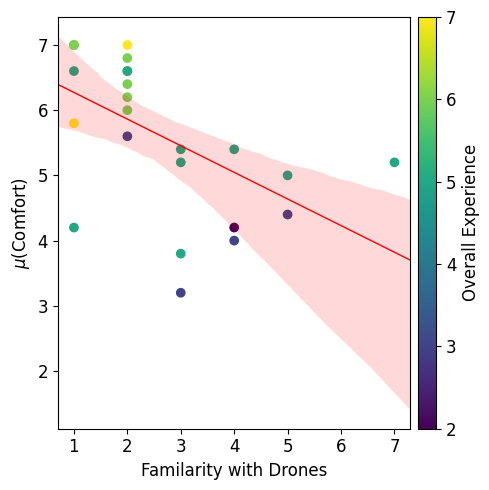

In [30]:
f,ax=plt.subplots(1,1,figsize=(5,5))
var=ax.scatter(df.familarity_with_drones, df.comfort_mean, c=df.overall_experience)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Overall Experience')

g1 = sns.regplot(x=df.familarity_with_drones,y=df.comfort_mean , data=df,
            ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('Familarity with Drones')
ax.set_ylabel('$\mu$(Comfort)')
mpl_functions.set_fontsize(ax,12)
f.tight_layout()

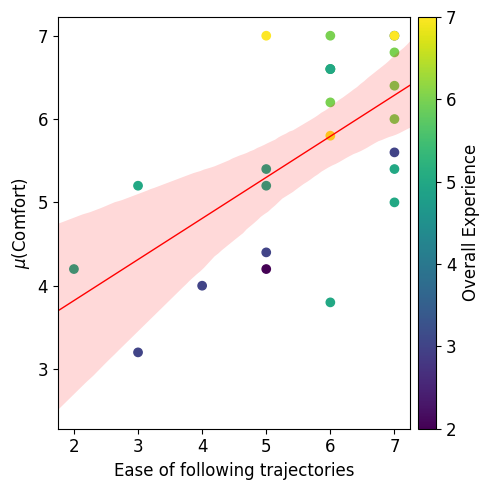

In [31]:
f,ax=plt.subplots(1,1,figsize=(5,5))
var=ax.scatter(df.easy_to_understand_drone_trajectory, df.comfort_mean, c=df.overall_experience)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Overall Experience')

g1 = sns.regplot(x=df.easy_to_understand_drone_trajectory,y=df.comfort_mean , data=df,
            ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('Ease of following trajectories')
ax.set_ylabel('$\mu$(Comfort)')
mpl_functions.set_fontsize(ax,12)
f.tight_layout()

### AIC Analysis

In [35]:
col = ['minutes_taken','age_group','gender','ethnicity','eye_sight_issues','familarity_with_robots', 'familarity_with_drones', 'overall_experience',
                                                      'easy_to_track' ,'stabilization_experience_improvement' ,
                                                      'easy_to_understand_drone_trajectory']


column_names=col
rsquaredres=[]
aicres=[]
para_list = []


for i in range(1,len(column_names)):
    sub_parameter_list = list(itertools.combinations(column_names,i))
  
    for elements in sub_parameter_list:
        para_list.append(elements)
        y=df.comfort_mean
        x = sm.add_constant(df.loc[df.comfort_mean.notnull(), elements].values)
        olsmod = sm.OLS(y, x)
        olsres = olsmod.fit()
        rsquaredres.append(olsres.rsquared)
        aicres.append(olsres.aic)
        
combtest=pd.DataFrame()
combtest['rsquared']=rsquaredres
combtest['aic']=aicres
combtest['parameters']=para_list
# combtest['fpvalue']=pval
# combtest['bic']=bicres


combtest['n_para']=np.zeros(len(combtest))
for i in range(len(combtest)):
    combtest.n_para[i]=len(combtest.parameters[i])



/tmp/ipykernel_302490/1851198674.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combtest.n_para[i]=len(combtest.parameters[i])


In [36]:
aic_min=[]
for i in range(1,int(combtest.n_para.max()+1)):
    aic_min.append(np.min(combtest.aic.iloc[(np.where(combtest.n_para==i))]))

aic_delta=[]
for i in range(len(aic_min)):
    if i ==0:
        aic_delta.append(0)
    else:
        aic_delta.append(aic_min[i]-aic_min[i-1])
        
aic_table=pd.DataFrame()
aic_table['aic_min'] = aic_min
aic_table['aic_delta']=aic_delta
aic_table

,aic_min,aic_delta
0,64.397520,0.000000
1,57.571835,-6.825686
2,53.484909,-4.086926
3,47.659562,-5.825346
4,47.688789,0.029226
5,43.983786,-3.705003
6,42.935206,-1.048580
7,41.522299,-1.412907
8,41.581608,0.059309
9,42.645779,1.064171


In [37]:
for i in range(1,len(aic_table)):
    print(*(combtest.parameters[combtest.aic==(combtest.aic.loc[(np.where(combtest.n_para==i))]).min()]))

('overall_experience',)
('overall_experience', 'easy_to_understand_drone_trajectory')
('minutes_taken', 'overall_experience', 'easy_to_understand_drone_trajectory')
('minutes_taken', 'familarity_with_drones', 'overall_experience', 'easy_to_understand_drone_trajectory')
('age_group', 'ethnicity', 'familarity_with_drones', 'stabilization_experience_improvement', 'easy_to_understand_drone_trajectory')
('age_group', 'gender', 'ethnicity', 'familarity_with_drones', 'stabilization_experience_improvement', 'easy_to_understand_drone_trajectory')
('minutes_taken', 'age_group', 'gender', 'ethnicity', 'familarity_with_drones', 'stabilization_experience_improvement', 'easy_to_understand_drone_trajectory')
('minutes_taken', 'age_group', 'gender', 'ethnicity', 'familarity_with_drones', 'overall_experience', 'stabilization_experience_improvement', 'easy_to_understand_drone_trajectory')
('minutes_taken', 'age_group', 'gender', 'ethnicity', 'familarity_with_robots', 'familarity_with_drones', 'overall_e

In [38]:
model_comfort_aic_filtered=smf.ols(formula="""comfort_mean ~ minutes_taken + overall_experience + 
                      familarity_with_drones + easy_to_understand_drone_trajectory """, data=df).fit()
print(model_comfort_aic_filtered.summary())

                            OLS Regression Results                            
Dep. Variable:           comfort_mean   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     17.18
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           4.12e-06
Time:                        11:33:07   Log-Likelihood:                -18.830
No. Observations:                  24   AIC:                             47.66
Df Residuals:                      19   BIC:                             53.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [40]:
# fig, ax = plt.subplots(figsize=(16, 8))
# summary = model_comfort_aic_filtered.summary().as_text()
# ax.text(0.01, 0.05, summary, fontfamily='monospace', fontsize=12, verticalalignment='bottom')
# ax.axis('off')
# fig.tight_layout()
# fig.savefig('output.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_302490/2217989078.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)
/tmp/ipykernel_302490/2217989078.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)


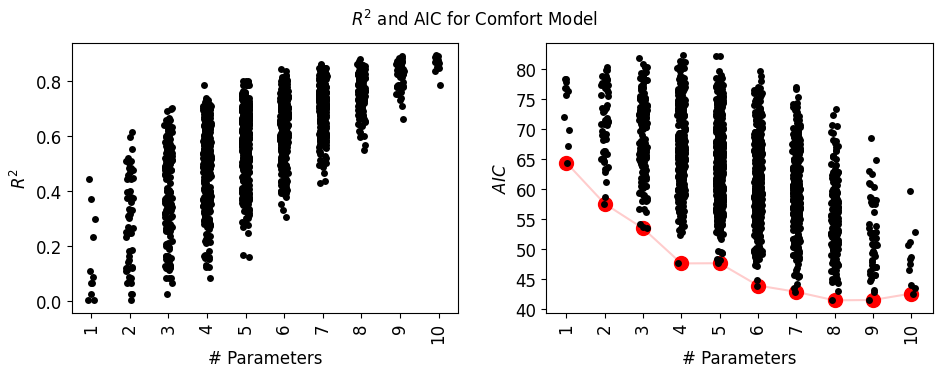

In [43]:
f,(ax,ax1)=plt.subplots(1,2,figsize=(10,4))
ax.grid(False)
ax.set_ylabel('$R^2$')
sns.stripplot(x=combtest.n_para,y=combtest.rsquared,data=combtest, 
              ax=ax, color='black',
              dodge=True, size=5)

ax.set_ylabel('$R^2$')
ax.set_xlabel('# Parameters')
ax.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)
# ax.set_title('$R^2$')

sns.stripplot(x=combtest.n_para,y=combtest.aic, data=combtest, color='black',
              ax=ax1,dodge=True, size=5)
ax1.set_xlabel('# Parameters')
ax1.set_ylabel('$AIC$')
ax1.grid(False)

ax1.scatter(np.arange(0,len(aic_table),1),aic_min,c='red', marker='o', facecolor=None,s=100)
ax1.plot(np.arange(0,len(aic_table),1),aic_min,c='red',alpha=0.2)

ax1.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)

f.tight_layout(pad=3)
f.suptitle('$R^2$ and AIC for Comfort Model')
mpl_functions.set_fontsize(f, 12)

### Calculating Semi Partial Correlation Coefficient to find the most contributing factors

In [ ]:
col = ['minutes_taken','age_group','gender','ethnicity','eye_sight_issues','familarity_with_robots', 'familarity_with_drones', 'overall_experience',
                                                      'easy_to_track' ,'stabilization_experience_improvement' ,
                                                      'easy_to_understand_drone_trajectory','comfort_mean']

partialdf = df[col].copy()
partialdf.fillna(0, inplace=True)

# semi-partial correlation for each predictor and square it
part_corr_squared = [pg.partial_corr(data=partialdf, x=col, y='comfort_mean',
                                     covar=partialdf.columns.drop([col, 'comfort_mean']).tolist()).r**2 for col in partialdf.columns[:-1]]
model = sm.OLS(partialdf['comfort_mean'], sm.add_constant(partialdf[partialdf.columns[:-1]])).fit()
r_squared = model.rsquared

percentage_contributions = (part_corr_squared / r_squared) * 100
contrib_df = pd.DataFrame({
    'Predictor': partialdf.columns[:-1],
    'Percentage Contribution': percentage_contributions.flatten()
})

contrib_df

,Predictor,Percentage Contribution
0,minutes_taken,20.646559
1,age_group,25.125389
2,gender,24.034478
3,ethnicity,32.284879
4,eye_sight_issues,0.270277
5,familarity_with_robots,6.789648
6,familarity_with_drones,33.643822
7,overall_experience,17.104610
8,easy_to_track,4.459126
9,stabilization_experience_improvement,38.893292


In [ ]:
contrib_df.loc[np.where(contrib_df['Percentage Contribution']>20)]

,Predictor,Percentage Contribution
0,minutes_taken,20.646559
1,age_group,25.125389
2,gender,24.034478
3,ethnicity,32.284879
6,familarity_with_drones,33.643822
9,stabilization_experience_improvement,38.893292
10,easy_to_understand_drone_trajectory,56.967433


### Clustering to see similar correlated groups

In [ ]:
# col = ['minutes_taken','age_group','gender','ethnicity','eye_sight_issues','familarity_with_robots', 'familarity_with_drones', 'overall_experience',
#                                                       'easy_to_track' ,'stabilization_experience_improvement' ,
#                                                      'easy_to_understand_drone_trajectory']
label = ['minutes_taken','age_group','gender','ethnicity','eye_sight_issues','familarity_with_robots', 'familarity_with_drones','overall_experience',
                                                      'easy_to_track' ,'stabilization_experience_improvement' ,
                                                     'easy_to_understand_drone_trajectory']


X=[df.minutes_taken, df.age_group, df.gender, df.ethnicity, df.eye_sight_issues,
       df.familarity_with_robots, df.familarity_with_drones, df.overall_experience,
       df.easy_to_track, df.stabilization_experience_improvement,
       df.easy_to_understand_drone_trajectory]

# X=df[col].copy()
y = df.comfort_mean

REMOVE_Y_CORR = True

corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):

        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)

            result = scipy.stats.linregress(resid_i, resid_j)

        corr_mat[i,j] = result.rvalue**2


In [ ]:
from scipy.cluster import hierarchy

rsq_matrix = corr_mat
dist_matrix = np.sqrt(1 - rsq_matrix)
condensed_dist_matrix = squareform(dist_matrix, checks=False)
Z = hierarchy.linkage(condensed_dist_matrix, 'ward')
clusters = hierarchy.fcluster(Z, t=1.0, criterion='distance')

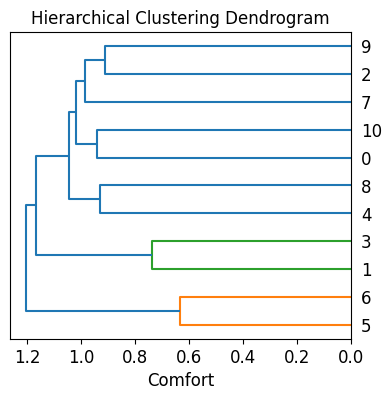

In [ ]:
f,ax=plt.subplots(1,1,figsize=(4, 4))
dn = hierarchy.dendrogram(Z, orientation='left')
int_list = [int(x) for x in dn['ivl']]
raesult = [col[i] for i in int_list]
ax.set_title('Hierarchical Clustering Dendrogram')
# ax.set_xlabel('Index')
ax.set_xlabel('Comfort')
ax.grid(False)

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

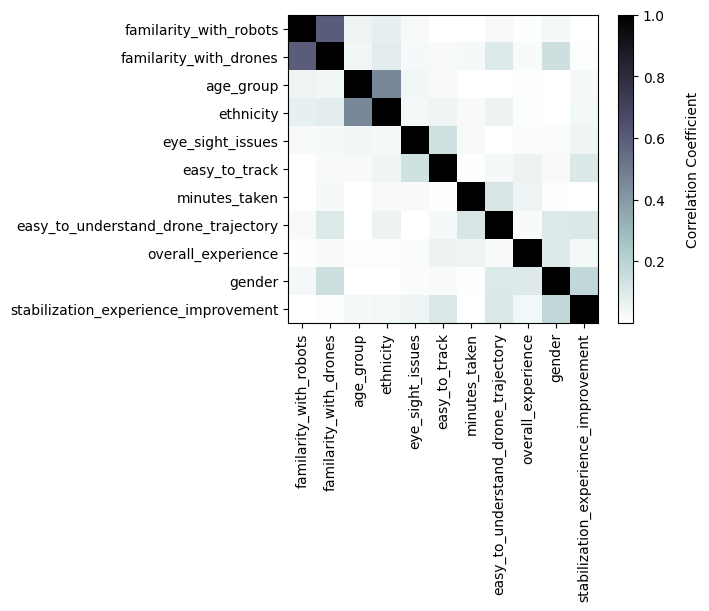

In [ ]:
# Convert the ndarray to a DataFrame
corr_mat_df = pd.DataFrame(corr_mat)

# Perform hierarchical clustering
Z_row = hierarchy.linkage(corr_mat_df, method='ward')
Z_col = hierarchy.linkage(corr_mat_df.T, method='ward')

# Get the order of rows and columns based on hierarchical clustering
row_order = hierarchy.leaves_list(Z_row)
col_order = hierarchy.leaves_list(Z_col)

# Reorder the data based on clustering
ordered_data = corr_mat_df.iloc[row_order, col_order]
ordered_data.index

new_names_ = [label[i] for i in ordered_data.index]
new_names_

f, ax = plt.subplots(figsize=(5, 4))
ax.grid(False)
cax = ax.imshow(ordered_data, cmap='bone_r', aspect='auto')

ax.set_xticks(np.arange(len(col_order)))
ax.set_yticks(np.arange(len(row_order)))
ax.set_xticklabels(new_names_, rotation=90)
ax.set_yticklabels(new_names_)

cbar = f.colorbar(cax, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=90, labelpad=15)

## Explanatory Plots
### Ethnicity and Familarity

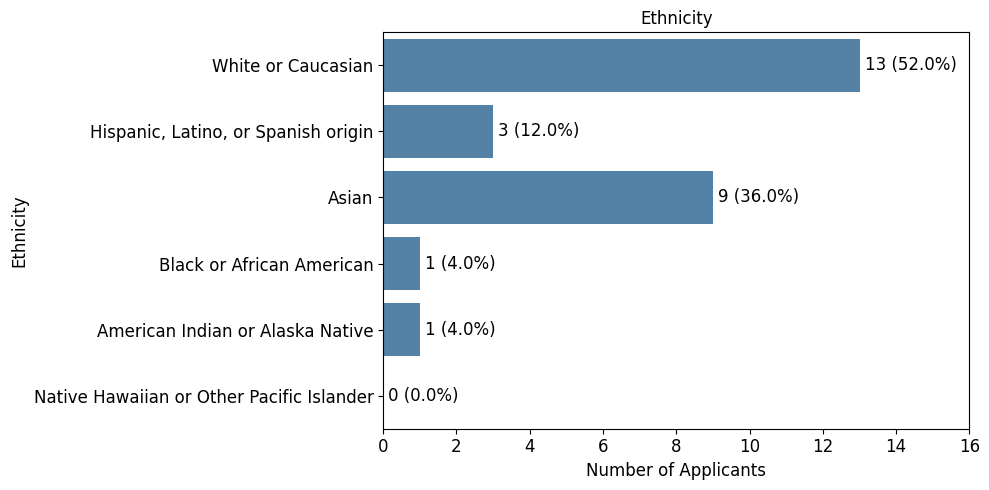

In [ ]:
data = {
    'Ethnicity': [
        'White or Caucasian', 'Hispanic, Latino, or Spanish origin', 'Asian',
        'Black or African American', 'American Indian or Alaska Native',
        'Native Hawaiian or Other Pacific Islander'
    ],
    'Count': [13, 3, 9, 1, 1, 0]
}

df1 = pd.DataFrame(data)

total_responses = 25

f, ax = plt.subplots(1, 1, figsize=(10, 5))
barplot = sns.barplot(x='Count', y='Ethnicity', data=df1, errorbar=None, color='steelblue')

for p in barplot.patches:
    count = int(p.get_width())  # Get the count for each bar
    percentage = f'{100 * count / total_responses:.1f}%'  # Calculate percentage based on total_responses
    x_position = p.get_width()
    # Adjust the threshold and position for annotation if necessary
    if x_position / total_responses > 0.55:
        x_position -= ax.get_xlim()[1] * 0.03
        color = 'white'
    else:
        x_position += ax.get_xlim()[1] * 0.01
        color = 'black'
    ax.annotate(f'{count} ({percentage})', (x_position, p.get_y() + p.get_height() / 2),
                va='center', ha='left', color=color)

ax.set_xlabel('Number of Applicants')
ax.set_title('Ethnicity')
ax.set_xlim(0, 16)  # Adjust the x-axis limit to fit the annotations if necessary

# mpl_functions.set_fontsize(ax, 12)
mpl_functions.set_fontsize(ax,12)
f.tight_layout()

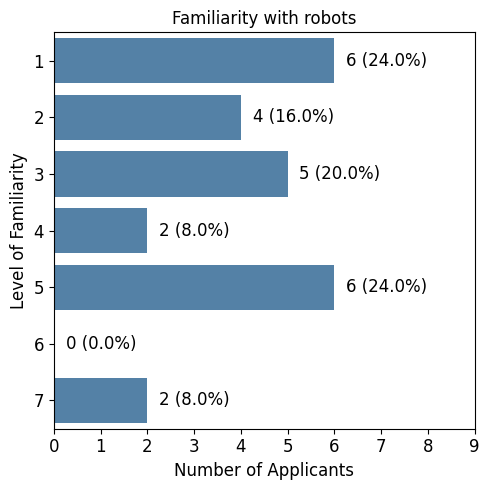

In [ ]:
data_robots = {
    'Level of Familiarity': ['1', '2', '3', '4', '5', '6', '7'],
    'Count': [6, 4, 5, 2, 6, 0, 2]
}

data_drones = {
    'Level of Familiarity': ['1', '2', '3', '4', '5', '6', '7'],
    'Count': [6, 8, 4, 3, 2, 0, 2]
}

df_robots = pd.DataFrame(data_robots)
df_drones = pd.DataFrame(data_drones)

def plot_familiarity(df, title, ax, color):
    barplot = sns.barplot(x='Count', y='Level of Familiarity', data=df, ax=ax, color=color, orient='h')
    total = df['Count'].sum()
    for p in barplot.patches:
        count = int(p.get_width())
        percentage = f'{100 * p.get_width() / total:.1f}%'
        x_position = p.get_width()
        if x_position > total * .55:
            x_position -= total * 0.03
            ax.annotate(f'{count} ({percentage})', (x_position, p.get_y() + p.get_height() / 2),
                        va='center', ha='right', color='white')
        else:
            x_position += total * 0.01
            ax.annotate(f'{count} ({percentage})', (x_position, p.get_y() + p.get_height() / 2),
                        va='center', ha='left')
    ax.set_xlabel('Number of Applicants')
    ax.set_title(title)

# Choose a single color for all bars
single_color = 'steelblue'

f, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_familiarity(df_robots, 'Familiarity with robots', axes, single_color)


axes.set_xlim(0,9)

mpl_functions.set_fontsize(axes,12)

f.tight_layout()

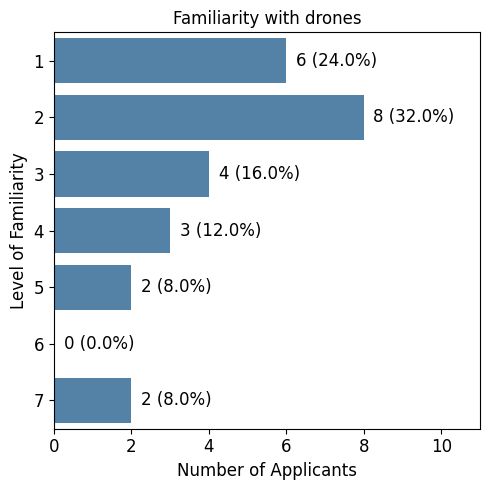

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_familiarity(df_drones, 'Familiarity with drones', axes, single_color)


axes.set_xlim(0,11)

mpl_functions.set_fontsize(axes,12)
f.tight_layout()